In [ ]:
# Import 라이브러리 

import pandas as pd
import numpy as np
from numpy.random import uniform
from random import sample
from math import isnan

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# Import Libraries for Data visualizations
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('./OnlineRetail_after.csv')
df.head(2)

,Unnamed: 0,CustomerID,Recency,Frequency,Amount
0,0,12346,325,2,0.00
1,1,12747,22,103,4196.01


In [ ]:
# Checking duplicates
print(sum(df.duplicated(subset = 'CustomerID')) == 0)

True


In [ ]:
# check missing values and types of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3950 non-null   int64  
 1   CustomerID  3950 non-null   int64  
 2   Recency     3950 non-null   int64  
 3   Frequency   3950 non-null   int64  
 4   Amount      3950 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 154.4 KB


In [ ]:
df = df.drop('Unnamed: 0', axis=1)
df.head(3)

,CustomerID,Recency,Frequency,Amount
0,12346,325,2,0.00
1,12747,22,103,4196.01
2,12748,4,4642,32034.17


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,3950.0,15562.029367,1576.848325,12346.00,14208.250,15571.500,16913.7500,18287.00
Recency,3950.0,100.417975,114.009397,-1.00,19.000,57.000,152.0000,696.00
Frequency,3950.0,91.614684,220.557389,1.00,17.000,41.000,101.0000,7983.00
Amount,3950.0,1742.702009,6556.472672,-4287.63,290.505,642.395,1562.0675,256438.49


In [ ]:
df.isna().sum()

CustomerID    0
Recency       0
Frequency     0
Amount        0
dtype: int64

# 문제1. 온라인 소비자 분석

## EDA를 통해 소비자 특성 등 인사이트를 도출하시오

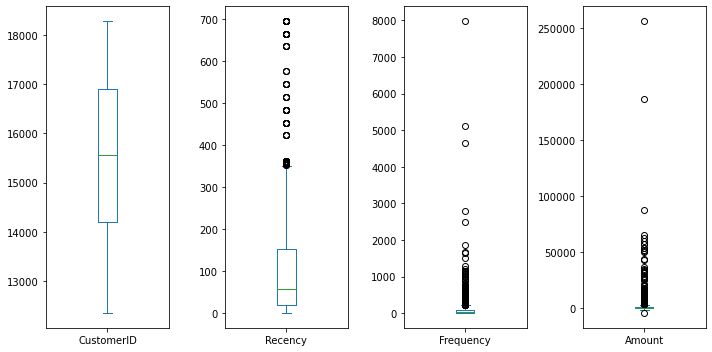

In [ ]:
# Plot box-plot to check the data outliers

fig, ax = plt.subplots(1,1, figsize=(10,5)) # 1개의 서브플롯에 ax를 배치하도록 fig를 설정
df.plot(kind='box', ax=ax,subplots=True) # box그래프를 ax[0]으로 지정
# sns.heatmap(df.corr(), ax=ax[1], annot=True, cmap='Blues', center=True, fmt='1f') # box그래프를 ax[1]으로 지정
plt.tight_layout()
plt.show()

In [ ]:
for col in df.columns[1:]:
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    L = df[col].quantile(0.25) - iqr*1.5
    U = df[col].quantile(0.75) + iqr*1.5
    print('IQR을 기반하여 {0}의 값이 {1:.2f}보다 작거나 {2:.2f}보다 크면 이상치로 간주한다.'.format(col, L, U))

IQR을 기반하여 Recency의 값이 -180.50보다 작거나 351.50보다 크면 이상치로 간주한다.
IQR을 기반하여 Frequency의 값이 -109.00보다 작거나 227.00보다 크면 이상치로 간주한다.
IQR을 기반하여 Amount의 값이 -1616.84보다 작거나 3469.41보다 크면 이상치로 간주한다.


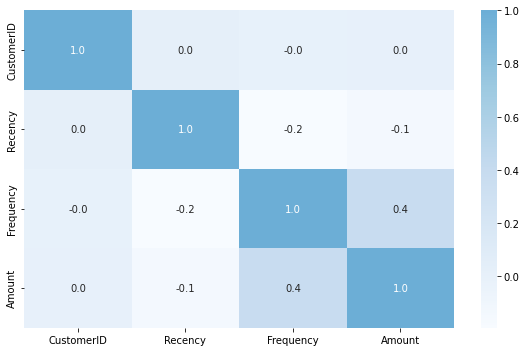

In [ ]:
# Plot heatmap to check the multicollinearity of the variables

fig, ax = plt.subplots(1,1, figsize=(8,5)) # 1개의 서브플롯에 ax를 배치하도록 fig를 설정
sns.heatmap(df.corr(), ax=ax, annot=True, cmap='Blues', center=True, fmt='.1f',) # box그래프를 ax[1]으로 지정
plt.tight_layout()
plt.show()

데이터타입 및 결측값
- 고객 3950명에 대한 미이용일수(Recency), 구매빈도(Frequency), 총구매금액(Amount)이 있다.
- 데이터타입은 변경하지 않고, Unnamed: 0 변수를 삭제, 결측값은 없다.
- 박스플롯 결과 미이용일수가 오래된 사람들이 이상치로 보이며, 구매빈도는 약 200건 이상 빈도의 고객이 이상치로 나온다. 평균(91.6건)>중위수(41건)이므로 오른쪽으로 긴꼬리의 분포를 가진다. 총구매액은 약 2500달러 이상 구매한 고객이 이상치로 나오며, 평균(1742.7달러)>중위수(642달러) 이므로 오른쪽으로 긴꼬리의 분포를 가진다.

이상치
- Recency의 값이 351.50건 보다 크면 이상치로 간주한다.
- Frequency의 값이 227.00건 보다 크면 이상치로 간주한다.
- Amount의 값이 3469.41 달러 보다 크면 이상치로 간주한다.

상관도
- 미이용일수와 구매빈도, 미이용일수와 구매총액은 각각의 상관계수가 -0.2, -0.1로 마이너스 관계이며 상관계수가 거의 존재하지 않는다.
- 구매빈도와 구매총액의 상관계수가 0.4로 약간의 양의 상관관계를 갖는다. 

이상치들도 고객을 군집화할 때 유용할 것이므로 모든데이터를 포함하여 분석을 진행하겠다.

### PCA기반  EDA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import IPython.display as display

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(df.iloc[:,1:]), columns=df.columns[1:])
X.index = df.CustomerID

In [ ]:
pca = PCA(n_components=3, random_state=123)
pca.fit(X)

PCA(n_components=3, random_state=123)

In [ ]:
pca.components_ # eigen vector

array([[-0.43456054,  0.65003848,  0.6233836 ],
       [ 0.89244965,  0.21764298,  0.39517737],
       [-0.12120544, -0.72806697,  0.67470566]])

In [ ]:
# Analyze the variance ratios of each features
pca.explained_variance_ratio_ # eigen value ratio

array([0.49734131, 0.29679813, 0.20586057])

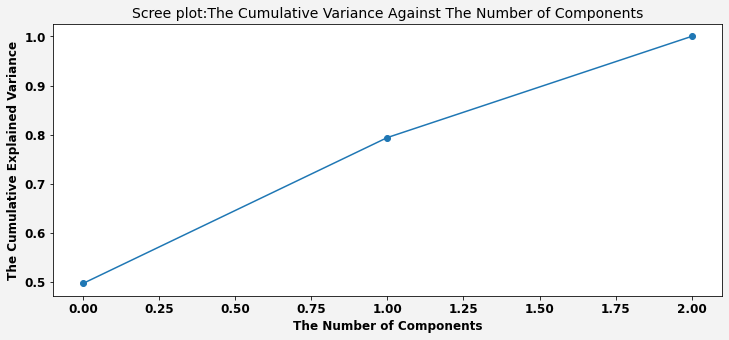

In [ ]:
# Plotting the Scree plot, i.e., the cumulative variance against the number of components
fig = plt.figure(figsize = (12,5))
fig.set_facecolor("#F3F3F3")
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Scree plot:The Cumulative Variance Against The Number of Components', fontsize=14)
plt.xlabel('The Number of Components', fontsize=12, fontweight='bold')
plt.ylabel('The Cumulative Explained Variance', fontsize=12,fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.show()

In [ ]:
colnames = list(df.columns[1:])
comp_df = pd.DataFrame({'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2]})
comp_df

,Feature,PC1,PC2,PC3
0,Recency,-0.434561,0.892450,-0.121205
1,Frequency,0.650038,0.217643,-0.728067
2,Amount,0.623384,0.395177,0.674706


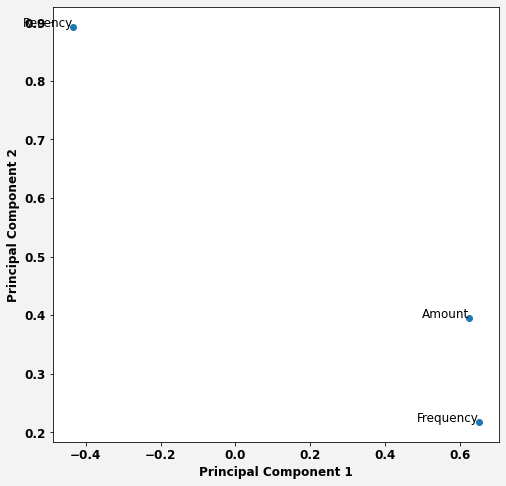

In [ ]:
# Visulaize the first two principal components
fig = plt.figure(figsize = (8,8))
fig.set_facecolor("#F3F3F3")
plt.scatter(comp_df.PC1, comp_df.PC2)
plt.xlabel('Principal Component 1',fontsize=12, fontweight='bold')
plt.ylabel('Principal Component 2',fontsize=12, fontweight='bold')
for i, txt in enumerate(comp_df.Feature):
    plt.annotate(txt, (comp_df.PC1[i],comp_df.PC2[i]),fontsize=12,  horizontalalignment='right')
plt.yticks(fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.show()

In [ ]:
pca_final = PCA(n_components=3)

In [ ]:
newdata_df = pca_final.fit_transform(X)
print('PCA Transformed Data of Three PC Data: ',newdata_df.shape)

PCA Transformed Data of Three PC Data:  (3950, 3)


In [ ]:
# Take the transpose of the PC matrix so that we can create the new matrix
pc3 = np.transpose(newdata_df)

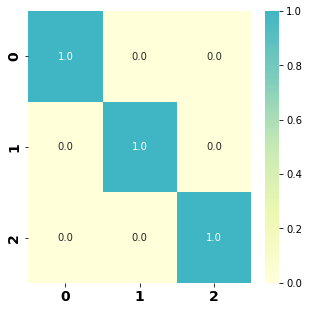

In [ ]:
# Create correlation matrix for the principal components
corrmat = np.corrcoef(pc3)

plt.figure(figsize = (5,5))  
fig.set_facecolor("#F3F3F3")
sns.heatmap(corrmat,cmap="YlGnBu",annot = True,fmt='.1f',center=True)
plt.yticks(fontsize=14, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Create the dataframe for three PC
prinComp_df = pd.DataFrame({'PC1':pc3[0],'PC2':pc3[1],'PC3':pc3[2]})
prinComp_df.head(6)

,PC1,PC2,PC3
0,-1.285996,1.564727,-0.122288
1,0.565785,-0.454800,0.298284
2,16.660842,5.561968,-11.802759
3,0.911909,-0.348236,-0.158040
4,0.042828,-0.522122,0.085289
5,-0.388605,-0.226372,0.118597


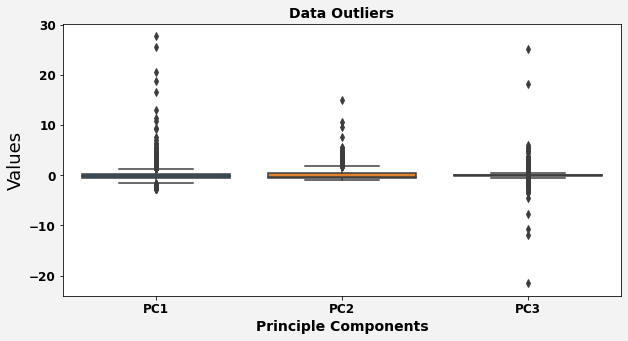

In [ ]:
# Checking outliers of five PC using box-plot
fig = plt.figure(figsize = (10,5))
fig.set_facecolor("#F3F3F3")
sns.boxplot(data=prinComp_df)
plt.title('Data Outliers', fontsize=14, fontweight='bold')
plt.ylabel('Values', fontsize=18);plt.xlabel('Principle Components',fontsize=14, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.show()

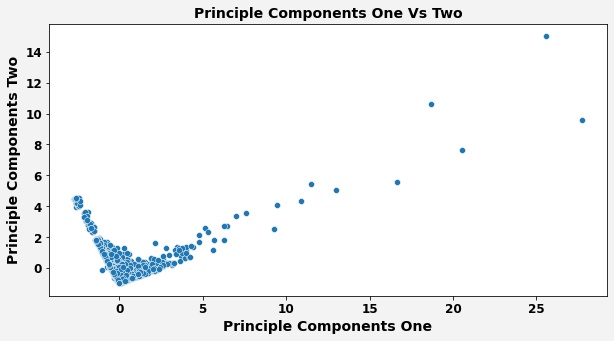

In [ ]:
# Let's check the spread of the dataset
fig = plt.figure(figsize = (10,5))
fig.set_facecolor("#F3F3F3")
sns.scatterplot(x='PC1',y='PC2',data=prinComp_df)
plt.title('Principle Components One Vs Two', fontsize=14, fontweight='bold')
plt.ylabel('Principle Components Two', fontsize=14,  fontweight='bold');plt.xlabel('Principle Components One',fontsize=14, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.show()

In [ ]:
prinComp_df

,PC1,PC2,PC3
0,-1.285996,1.564727,-0.122288
1,0.565785,-0.454800,0.298284
2,16.660842,5.561968,-11.802759
3,0.911909,-0.348236,-0.158040
4,0.042828,-0.522122,0.085289
...,...,...,...
3945,-0.612432,0.283919,0.046388
3946,-0.036075,-0.946357,0.211890
3947,-0.348559,-0.237894,0.107310
3948,2.362670,-0.024626,-2.035824


In [ ]:
# Assigning prinComp_df dataframe to a new variable
df_pca = prinComp_df

## 계층적 군집분석(Hierarchical Clustering)

In [1]:
# Create the dataframe for three PC
df_pca = pd.DataFrame({'PC1':pc3[0],'PC2':pc3[1],'PC3':pc3[2]})
df_pca.head(6)

NameError: ignored

In [ ]:
# 거리 계산
# median : 중앙중심법
# ward: 연결될 수 있는 군집 조합을 만들고, 군집 내 편차들의 제곱합을 기준으로 최소 제곱합을 가지게 되는 군집끼리 연결
mergings=linkage(y = df_pca, method='ward', metric='euclidean') # y: 거리계산할 거리행렬(스케일링한_data)

In [ ]:
# 덴드로그램 그리기 
fig = plt.figure(figsize = (20,15))
fig.set_facecolor("#F3F3F3")
dendrogram(mergings)
plt.title('Hierarchical Clustering:- Ward Linkage Mergings', fontsize=18, fontweight='bold')
plt.ylabel('Distance', fontsize=18)
plt.xlabel('Sample Index (Cluster size)', fontsize=18, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(size = 13, fontweight='bold')
plt.show()

In [ ]:
# cut_tree함수를 이용해서 군집 수 결정
cut_tree(mergings, n_clusters=3).shape

In [ ]:
clusterCut_labels = cut_tree(mergings, n_clusters = 3).reshape(-1,)
clusterCut_labels[:50]

In [ ]:
# df_hclust : Concat hcluster labels to PCA analyzed dataframe

df_pca=prinComp_df
df_pca.index = pd.RangeIndex(len(df['CustomerID']))
df_hclust = pd.concat([df_pca, pd.Series(clusterCut_labels)], axis=1)
df_hclust.columns = ['PC1', 'PC2','PC3','ClusterID_H']
df_hclust.head(6)

In [ ]:
fig = plt.figure(figsize = (10,5))
fig.set_facecolor("#F3F3F3")

colr = {0: "r", 1: "b", 2:"g", 3:'k'}
sns.scatterplot(x="PC1", y="PC2", data=df_hclust, hue = "ClusterID_H",palette=colr)
plt.legend(fontsize=12, loc='lower right') 
plt.title('Hierarchical Clustering:- PC1 Vs. PC2',fontsize=14, fontweight='bold')
plt.ylabel('PC2', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')
plt.show()

In [ ]:
df_hclust_total=pd.merge(df, df_hclust, left_index=True,right_index=True)
df_hclust_total.head(2)

In [ ]:
df_hclust_final=df_hclust_total.drop(['PC1','PC2','PC3'],axis=1)
print('Shape of Hierarchical Clustering Dataset: ',df_hclust_final.shape)

In [ ]:
# Review the H-clustering final dataset
df_hclust_final.head(6)

In [ ]:
# Number of clusters and number of Customer in each cluster
print("H-clustering: The Number of Clusters and Number of Customer in Each Cluster")
print(df_hclust_final['ClusterID_H'].value_counts())

In [ ]:
# Analyse the mean of all the variables of each cluster obtained after H clustering

cluster_Recency=pd.DataFrame(df_hclust_final.groupby(["ClusterID_H"]).Recency.mean())
cluster_Frequency=pd.DataFrame(df_hclust_final.groupby(["ClusterID_H"]).Frequency.mean())
cluster_Amount=pd.DataFrame(df_hclust_final.groupby(["ClusterID_H"]).Amount.mean())

In [ ]:
# Merge the dataset
df_h =pd.concat([cluster_Recency,cluster_Frequency,cluster_Amount],axis=1).reset_index()
df_h

In [ ]:
def replace_number_to_name(x,y):
    df_h.ClusterID_H.replace(x,y, inplace=True)

replace_number_to_name(0,'normal')
replace_number_to_name(1,'vip')
replace_number_to_name(2,'vvip')

print("1."+ "Replaced 0 to normal")
print("2."+"Replaced 1 to vip")
print("3."+ "Replaced 2 to vvip")

df_h.head(2)

In [ ]:
df_h.sort_values(by=['Recency'],ascending=False).ClusterID_H

In [ ]:
fig = plt.figure(figsize = (20,5))
fig.set_facecolor("#F3F3F3")

plt.subplot(121)

colr = {'normal': 'r' , 'vip': 'y' , 'vvip':'b'}

sns.barplot(data=df_h.sort_values(by=['Recency'],ascending=False),
            x='ClusterID_H',y='Recency', 
            hue=df_h.sort_values(by=['Recency'],ascending=False).ClusterID_H,
            palette=colr,dodge=False)

plt.legend([],[], frameon=False)
plt.title('H Clustering:- Customer Classfied into Groups \nRecency', fontsize=14, fontweight='bold')
plt.ylabel('Recency', fontsize=12, fontweight='bold')
plt.xlabel('Customer Classified into Groups', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(rotation=90, fontsize=11, fontweight='bold')

plt.subplot(122)
colr = {'normal': 'r' , 'vip': 'y' , 'vvip':'b'}

sns.boxplot(x='ClusterID_H',y='Recency',
         data=df_h.sort_values(by=['Recency'],ascending=False), palette=colr,
         order = df_h.sort_values(by=['Recency'],ascending=False).ClusterID_H)

plt.title('H Clustering:- Customer Classfied into Groups \nRecency',fontsize=14,fontweight='bold')
plt.xlabel('Customer Classified into Groups', fontsize=14, fontweight='bold')
plt.ylabel('Recency', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(rotation=90, fontsize=11, fontweight='bold')

plt.show()

In [ ]:
fig = plt.figure(figsize = (20,5))
fig.set_facecolor("#F3F3F3")

plt.subplot(121)

colr = {'normal': 'r' , 'vip': 'y' , 'vvip':'b'}

sns.barplot(data=df_h.sort_values(by=['Frequency']),
            x='ClusterID_H',y='Frequency', 
            hue=df_h.sort_values(by=['Frequency']).ClusterID_H,
            palette=colr,dodge=False)

plt.legend([],[], frameon=False)
plt.title('H Clustering:- Customer Classfied into Groups \nFrequency', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xlabel('Customer Classified into Groups', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(rotation=90, fontsize=11, fontweight='bold')

plt.subplot(122)
colr = {'normal': 'r' , 'vip': 'y' , 'vvip':'b'}

sns.boxplot(x='ClusterID_H',y='Frequency',
         data=df_h.sort_values(by=['Frequency']), palette=colr,
         order = df_h.sort_values(by=['Frequency']).ClusterID_H)

plt.title('H Clustering:- Customer Classfied into Groups \nFrequency',fontsize=14,fontweight='bold')
plt.xlabel('Customer Classified into Groups', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(rotation=90, fontsize=11, fontweight='bold')

plt.show()

In [ ]:
fig = plt.figure(figsize = (20,5))
fig.set_facecolor("#F3F3F3")

plt.subplot(121)

colr = {'normal': 'r' , 'vip': 'y' , 'vvip':'b'}

sns.barplot(data=df_h.sort_values(by=['Amount']),
            x='ClusterID_H',y='Amount', 
            hue=df_h.sort_values(by=['Amount']).ClusterID_H,
            palette=colr,dodge=False)

plt.legend([],[], frameon=False)
plt.title('H Clustering:- Customer Classfied into Groups \nAmount', fontsize=14, fontweight='bold')
plt.ylabel('Amount', fontsize=12, fontweight='bold')
plt.xlabel('Customer Classified into Groups', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(rotation=90, fontsize=11, fontweight='bold')

plt.subplot(122)
colr = {'normal': 'r' , 'vip': 'y' , 'vvip':'b'}

sns.boxplot(x='ClusterID_H',y='Amount',
         data=df_h.sort_values(by=['Amount']), palette=colr,
         order = df_h.sort_values(by=['Amount']).ClusterID_H)

plt.title('H Clustering:- Customer Classfied into Groups \nAmount',fontsize=14,fontweight='bold')
plt.xlabel('Customer Classified into Groups', fontsize=14, fontweight='bold')
plt.ylabel('Amount', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(rotation=90, fontsize=11, fontweight='bold')

plt.show()

## 비계층적 군집분석(K-Means Clustering)

In [ ]:
# Silhouette Analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_pca)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print("For n_clusters,", num_clusters,"the silhouette score is ",silhouette_avg)

For n_clusters, 2 the silhouette score is  0.9332011737463057
For n_clusters, 3 the silhouette score is  0.5429019465000503
For n_clusters, 4 the silhouette score is  0.5436916579265539
For n_clusters, 5 the silhouette score is  0.5751218357229654
For n_clusters, 6 the silhouette score is  0.5493752206279326
For n_clusters, 7 the silhouette score is  0.5590371688887218
For n_clusters, 8 the silhouette score is  0.4771837222315545


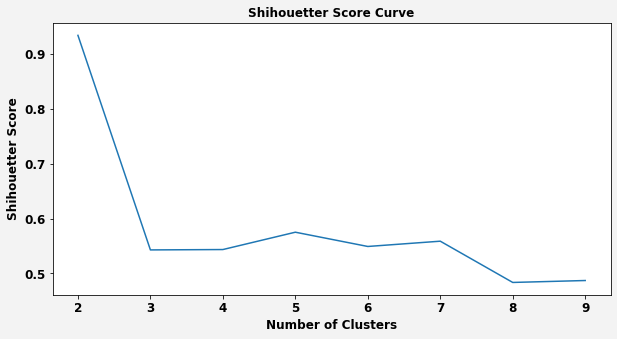

In [ ]:
# Sihouette score
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(df_pca)
    sse.append([k, silhouette_score(df_pca, kmeans.labels_)])
    
fig = plt.figure(figsize = (10,5))
fig.set_facecolor("#F3F3F3")
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1])
plt.title('Shihouetter Score Curve', fontsize=12, fontweight='bold')
plt.ylabel('Shihouetter Score', fontsize=12, fontweight='bold');plt.xlabel('Number of Clusters',fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.show()

- Shihouetter score curve는 3그룹일 때 팔꿈치인것을 보여줌(SSE감소량이 급격히 감소하는 구간)

In [ ]:
km = KMeans(n_clusters = 3, max_iter=50,random_state = 123)
km.fit(df_pca)

KMeans(max_iter=50, n_clusters=3, random_state=123)

In [ ]:
cluster_labels = km.fit_predict(df_pca)
cluster_labels # 선정 클러스터 

array([0, 2, 1, ..., 2, 2, 2])

In [ ]:
# Concat Kmeans Modelculst1 to PCA analyzed dataframe

df_pca.index = pd.RangeIndex(len(df_pca.index))
df_kmean = pd.concat([df_pca, pd.Series(km.labels_)], axis=1)
df_kmean.columns = ['PC1', 'PC2','PC3','ClusterID_K']
df_kmean.head(5)

,PC1,PC2,PC3,ClusterID_K
0,-1.285996,1.564727,-0.122288,0
1,0.565785,-0.454800,0.298284,2
2,16.660842,5.561968,-11.802759,1
3,0.911909,-0.348236,-0.158040,2
4,0.042828,-0.522122,0.085289,2


In [ ]:
# 클러스터 별 고객 수
print(df_kmean['ClusterID_K'].value_counts())

2    2931
0    1009
1      10
Name: ClusterID_K, dtype: int64


In [ ]:
df_kmeans_total=pd.merge(df,df_kmean, left_index=True,right_index=True)
df_kmeans_total.head(2)

,CustomerID,Recency,Frequency,Amount,PC1,PC2,PC3,ClusterID_K
0,12346,325,2,0.00,-1.285996,1.564727,-0.122288,0
1,12747,22,103,4196.01,0.565785,-0.454800,0.298284,2


In [ ]:
df_kmeans_final=df_kmeans_total.drop(['PC1','PC2','PC3'],axis=1)
print('Shape of Hierarchical Clustering Dataset: ',df_kmeans_final.shape)

Shape of Hierarchical Clustering Dataset:  (3950, 5)


In [ ]:
# Analyse the mean of all the variables of each cluster obtained after K mean -used goupby function

cluster_Recency=pd.DataFrame(df_kmeans_final.groupby(["ClusterID_K"]).Recency.mean())
cluster_Frequency=pd.DataFrame(df_kmeans_final.groupby(["ClusterID_K"]).Frequency.mean())
cluster_Amount=pd.DataFrame(df_kmeans_final.groupby(["ClusterID_K"]).Amount.mean())

In [ ]:
# Merge all the groupby dataset
df_k=pd.concat([cluster_Recency,cluster_Frequency,cluster_Amount],axis=1).reset_index()
df_k

,ClusterID_K,Recency,Frequency,Amount
0,0,260.810704,29.184341,406.012319
1,1,9.200000,2838.300000,84564.787000
2,2,45.513818,103.735244,1920.286126


In [ ]:
print("1."+"Replaced 0 to normal")
print("2."+ "Replaced 1 to vvip")
print("3."+ "Replaced 2 to vip")

def replace_number_to_name(x,y):
    df_k.ClusterID_K.replace(x,y, inplace=True)

replace_number_to_name(0,'normal')
replace_number_to_name(1,'vvip')
replace_number_to_name(2,'vip')

1.Replaced 0 to normal
2.Replaced 1 to vvip
3.Replaced 2 to vip


In [ ]:
# Review the Data columns after repalcing 0, 1, and 2

print("ClusterID Unique Value:")
print(df_k.ClusterID_K.unique())

ClusterID Unique Value:
['normal' 'vvip' 'vip']


In [ ]:
df_k

,ClusterID_K,Recency,Frequency,Amount
0,normal,260.810704,29.184341,406.012319
1,vvip,9.200000,2838.300000,84564.787000
2,vip,45.513818,103.735244,1920.286126


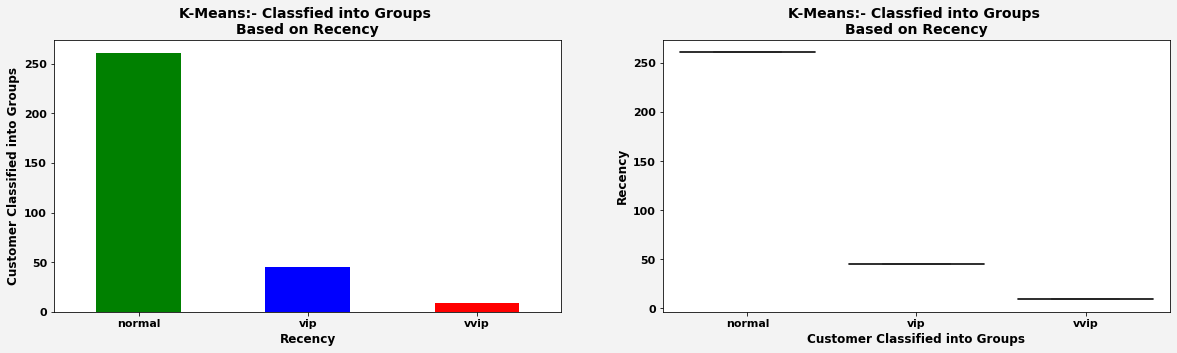

In [ ]:
fig = plt.figure(figsize = (20,5))
fig.set_facecolor("#F3F3F3")

ax1 = fig.add_subplot(121)
colr = {"normal": "g", "vip": "b", "vvip":"r"}
df_k.sort_values(by='Recency', ascending=False).plot.bar(x='ClusterID_K', y='Recency', rot=0, legend=False, fontsize=12, color=['g','b', 'r'], ax=ax1)
# plt.xticks([0,1,2,3,4,5,6],['월','화','수','목','금','토','일'])
plt.title('K-Means:- Classfied into Groups \nBased on Recency', fontsize=14, fontweight='bold')
plt.ylabel('Customer Classified into Groups', fontsize=12, fontweight='bold')
plt.xlabel('Recency', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')

plt.subplot(122)
colr = {"normal": "g", "vip": "b", "vvip":"r"}
sns.boxplot(x='ClusterID_K',y='Recency',data=df_k, palette=colr,
           order = ['normal', 'vip','vvip'])
plt.title('K-Means:- Classfied into Groups \nBased on Recency',  fontsize=14, fontweight='bold')
plt.xlabel('Customer Classified into Groups', fontsize=12, fontweight='bold')
plt.ylabel('Recency', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')
plt.show()

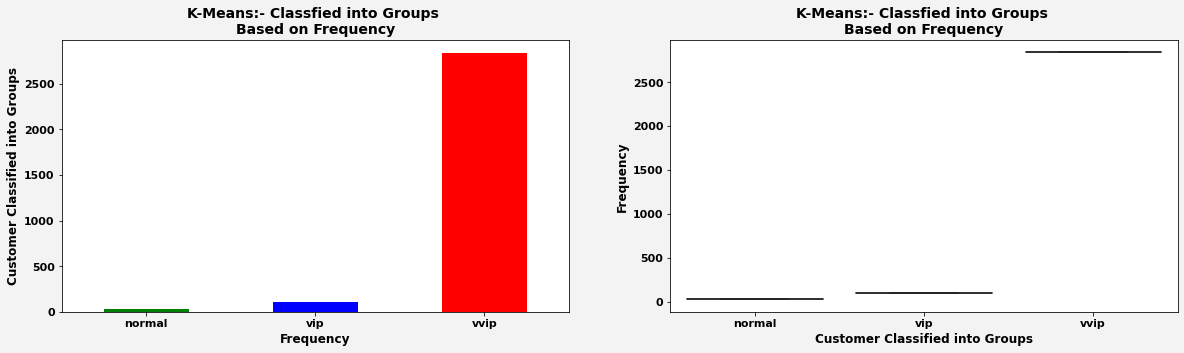

In [ ]:
fig = plt.figure(figsize = (20,5))
fig.set_facecolor("#F3F3F3")

ax1 = fig.add_subplot(121)
colr = {"normal": "g", "vip": "b", "vvip":"r"}
df_k.sort_values(by='Frequency').plot.bar(x='ClusterID_K', y='Frequency', rot=0, legend=False, 
                                          fontsize=12,color=['g','b', 'r'], ax=ax1)

ax1.set_xticklabels(['normal','vip','vvip']) # 껍데기만 바뀌는거라 위험

plt.title('K-Means:- Classfied into Groups \nBased on Frequency', fontsize=14, fontweight='bold')
plt.ylabel('Customer Classified into Groups', fontsize=12, fontweight='bold')
plt.xlabel('Frequency', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')

plt.subplot(122)
colr = {"normal": "g", "vip": "b", "vvip":"r"}
sns.boxplot(x='ClusterID_K',y='Frequency',data=df_k, palette=colr,
           order = ['normal', 'vip','vvip'])
plt.title('K-Means:- Classfied into Groups \nBased on Frequency',  fontsize=14, fontweight='bold')
plt.xlabel('Customer Classified into Groups', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')
plt.show()

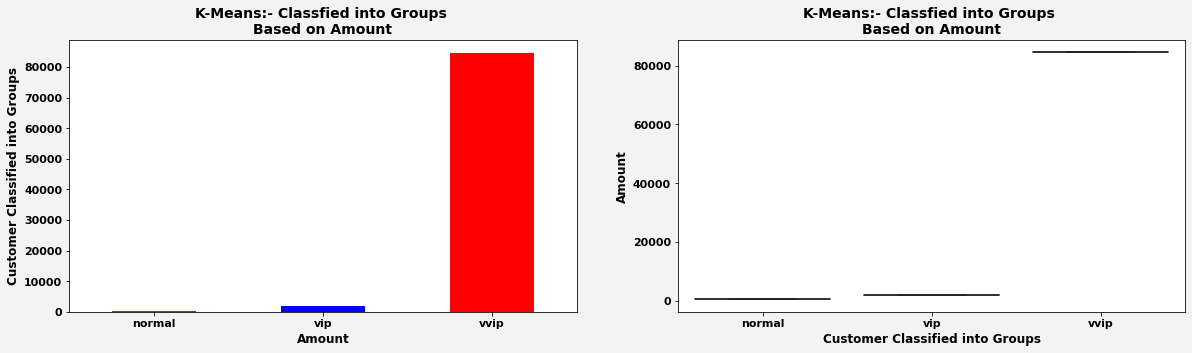

In [ ]:
fig = plt.figure(figsize = (20,5))
fig.set_facecolor("#F3F3F3")

ax1 = fig.add_subplot(121)

df_k.sort_values(by='Amount').plot.bar(x='ClusterID_K', y='Amount', rot=0, legend=False, fontsize=12,color=['g','b', 'r'], ax=ax1)
plt.title('K-Means:- Classfied into Groups \nBased on Amount', fontsize=14, fontweight='bold')
plt.ylabel('Customer Classified into Groups', fontsize=12, fontweight='bold')
plt.xlabel('Amount', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')

plt.subplot(122)
colr = {"normal": "g", "vip": "b", "vvip":"r"}
sns.boxplot(x='ClusterID_K',y='Amount',data=df_k, palette=colr,
           order = ['normal', 'vip','vvip'])
plt.title('K-Means:- Classfied into Groups \nBased on Amount',  fontsize=14, fontweight='bold')
plt.xlabel('Customer Classified into Groups', fontsize=12, fontweight='bold')
plt.ylabel('Amount', fontsize=12, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')
plt.show()

## 최종적으로 고객에 대한 마케팅 전략을 수립하시오

In [ ]:
from sklearn.metrics import silhouette_score
print( silhouette_score(df_pca,clusterCut_labels ))
print( silhouette_score(df_pca, cluster_labels)) # V 

0.5054988669513911
0.5429019465000503


In [ ]:
d = pd.concat([df_hclust_final, df_kmeans_final],axis=1)
d

,CustomerID,Recency,Frequency,Amount,ClusterID_H,CustomerID,Recency,Frequency,Amount,ClusterID_K
0,12346,325,2,0.00,0,12346,325,2,0.00,0
1,12747,22,103,4196.01,1,12747,22,103,4196.01,2
2,12748,4,4642,32034.17,2,12748,4,4642,32034.17,1
3,12749,22,231,3868.20,1,12749,22,231,3868.20,2
4,12820,44,59,942.34,1,12820,44,59,942.34,2
...,...,...,...,...,...,...,...,...,...,...
3945,18280,159,10,180.60,0,18280,159,10,180.60,0
3946,18281,3,7,80.82,1,18281,3,7,80.82,2
3947,18282,92,13,176.60,1,18282,92,13,176.60,2
3948,18283,9,756,2329.67,1,18283,9,756,2329.67,2


In [ ]:
d = d.loc[:,['ClusterID_H','ClusterID_K']]
from sklearn.metrics import confusion_matrix
confusion_matrix(d['ClusterID_H'],d['ClusterID_K'])

array([[1009,    0,  247],
       [   0,    5, 2684],
       [   0,    5,    0]], dtype=int64)

In [ ]:
# replace_number_to_name(0,'normal')
# replace_number_to_name(1,'vvip')
# replace_number_to_name(2,'vip')

In [ ]:
def change(v):
    if v ==1:
        return 2
    elif v==2:
        return 1
    else:
        return 0
d['ClusterID_K'] = d['ClusterID_K'].apply(change)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(d['ClusterID_K'], d['ClusterID_H']))
print(accuracy_score(d['ClusterID_K'], d['ClusterID_H']))

[[1009    0    0]
 [ 247 2684    0]
 [   0    5    5]]
0.9362025316455697


In [ ]:
df_k['count'] = df_kmeans_final['ClusterID_K'].value_counts().sort_index()
df_k

,ClusterID_K,Recency,Frequency,Amount,count
0,normal,260.810704,29.184341,406.012319,1009
1,vvip,9.200000,2838.300000,84564.787000,10
2,vip,45.513818,103.735244,1920.286126,2931


- 실루엣 계수를 비교한 결과 hcluster가 0.51, k-means가 0.54로 kmeans로 분류된 고객들을 선정하겠다
- vvip : 10명이지만 매출액에 대부분을 차지하므로 로얄 맴버십혜택 카드(순금)와 함께 다양한 혜택을 준다.
- vip: 1~2개월에 한번씩은 우리 온라인 쇼핑점을 이용하는 고객들이기 때문에 맴버십혜택을 통해 소비를 유도
- normal: 투입하지 않는다

## 추가적인 고객 분석을 하고자 할 때 어떤 방식이 좋을지 논하시오

- 연관분석을 통하여 군집별로 lift가 높은 상품을 추천

# 문제2. 금시세와 코로나19 확진자수 분석(시계열분석)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats


df = pd.read_csv('./covid19_wc.csv')
gold = pd.read_csv('./gold.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  844 non-null    int64 
 1   date        844 non-null    object
 2   cases       844 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 19.9+ KB


In [ ]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      5735 non-null   object 
 1   Open      5735 non-null   float64
 2   High      5735 non-null   float64
 3   Low       5735 non-null   float64
 4   Close     5735 non-null   float64
 5   Volume    5735 non-null   int64  
 6   Currency  5735 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 313.8+ KB


## 위 두 데이터셋을 불러와서 covid19_wc 데이터셋의 날짜 기준으로 merge(inner join)하고 [’date’, ‘ cases’, ‘ Close’] 3개의 변수를 갖는 데이터셋으로 만드시오. 

In [ ]:
data = pd.merge(left = df, right = gold, how='inner', on='date') # inner : 양쪽 모두 가지고 있어야 함
data = data.loc[:,['date', 'cases', 'Close']]
data.head(5)


,date,cases,Close
0,2020-01-21,1,1557.9
1,2020-01-22,1,1556.7
2,2020-01-23,1,1565.4
3,2020-01-24,1,1571.9
4,2020-01-27,1,1577.4


## 코로나 확진자수에 따라 금시세가 변하는지 회귀분석을 실시하시오.

In [ ]:
# correlation
import numpy as np
import scipy.stats as stats
stats.pearsonr(data['cases'], data['Close'])

(0.38259197380868787, 9.845899846878778e-23)

In [ ]:
from statsmodels.formula.api import ols
model = ols('Close ~ cases',data=data,)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     104.4
Date:                Sun, 05 Jun 2022   Prob (F-statistic):           9.85e-23
Time:                        20:10:45   Log-Likelihood:                -3636.8
No. Observations:                 611   AIC:                             7278.
Df Residuals:                     609   BIC:                             7287.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1769.3226      5.331    331.908      0.000    1758.854    1779.792
cases       8.358e-05   8.18e-06     10.219      0.000    6.75e-05    9.96e-05
==============================================================================
Omnibus:                        3.608   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                4.201
Skew:                          -0.022   Prob(JB):                        0.122
Kurtosis:                       3.404   Cond. No.                     9.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

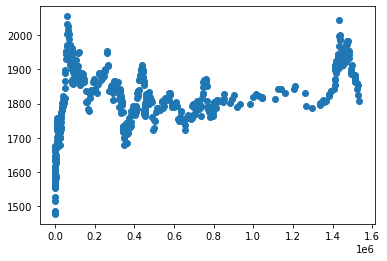

In [ ]:
plt.scatter(x = data['cases'], y = data['Close'])
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(np.array(data['Close']).reshape(-1,1))
exog_train_sc = sc.fit_transform(np.array(data['cases']).reshape(-1,1))

d = pd.concat([pd.Series(train_sc.ravel()), pd.Series(exog_train_sc.ravel())],axis=1)
d.columns = ['Gold', 'Covid19_Cases']

In [ ]:
from statsmodels.formula.api import ols
model = ols('Gold ~ Covid19_Cases -1',data=d) # 끝에 ' -1' 상수 제거
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Gold   R-squared (uncentered):                   0.570
Model:                            OLS   Adj. R-squared (uncentered):              0.569
Method:                 Least Squares   F-statistic:                              808.6
Date:                Sun, 05 Jun 2022   Prob (F-statistic):                   6.91e-114
Time:                        20:38:53   Log-Likelihood:                         -295.15
No. Observations:                 611   AIC:                                      592.3
Df Residuals:                     610   BIC:                                      596.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Covid19_Cases     1.0631      0.037     28.436      0.000       0.990       1.136
==============================================================================
Omnibus:                       14.841   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.692
Skew:                          -0.167   Prob(JB):                      0.00786
Kurtosis:                       2.482   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##  훈련 데이터와 테스트 데이터 셋을 80:20으로 분할하여 진행하시오. 

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [ ]:

# 시계열 데이터 분할 : 스케일링 전에 분할
train = data.iloc[0:int(len(data['cases'])*0.8)]
test = data.iloc[int(len(data['cases'])*0.8):]
train.head()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_sc = sc.fit_transform(np.array(train['Close']).reshape(-1,1))
exog_train_sc = sc.fit_transform(np.array(train['cases']).reshape(-1,1))

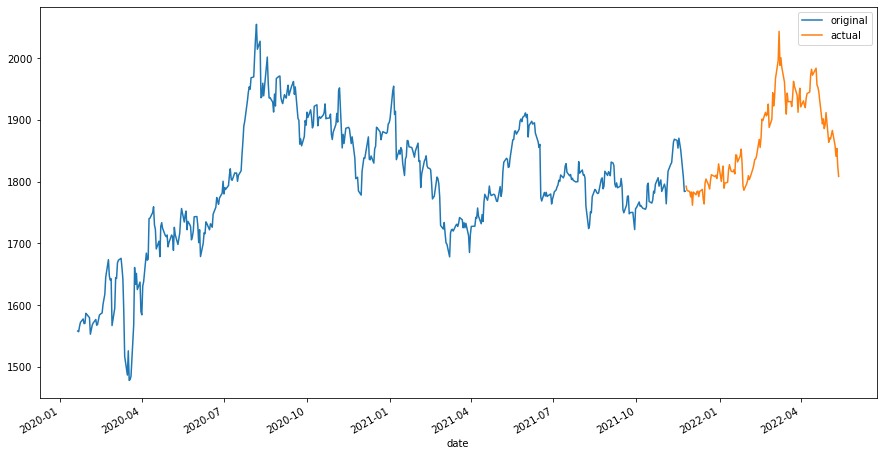

In [ ]:
train['Close'].plot(figsize=(15,8), label='original')
test['Close'].plot(label = 'actual')
plt.legend()
plt.show()

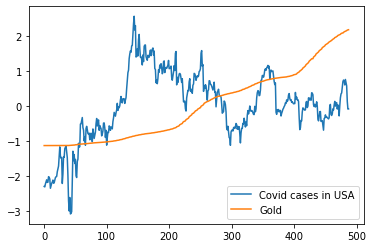

In [ ]:
# 스케일링한 후 두 시계열 그래프
plt.plot(train_sc, label='Covid cases in USA')
plt.plot(exog_train_sc, label='Gold')
plt.legend()
plt.show()

### 금시세를 예측하기 위해서 금시세(종가 기준) 한 개 변수를 가지고 시계열 모델을 적합하시오.

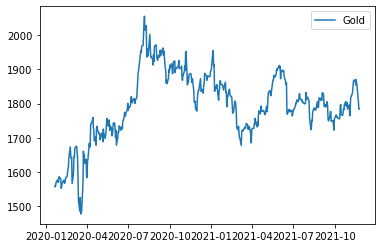

In [ ]:
plt.plot(train['Close'], label='Gold')
plt.legend()
plt.show()

- 금 데이터의 경우 장기적 주기가 증가하는 추세가 관측 됨 - 비정상성 시계열

In [ ]:
# 정상성 검정
from statsmodels.tsa.stattools import adfuller, kpss
print("ADF test : ", adfuller(train['Close'])[1]) # H0: 정상시계열이 아니다.
print("KPSS test : ", kpss(train['Close'])[1]) # H0: 정상시계열이다.

ADF test :  0.05337975634748434
KPSS test :  0.01


In [ ]:
import pmdarima
from pmdarima.arima import ndiffs,nsdiffs
import pmdarima as pm

In [ ]:
# 금가격 차분 차수 추정 
kpss_diffs = ndiffs(train['Close'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train['Close'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


<AxesSubplot:xlabel='date'>

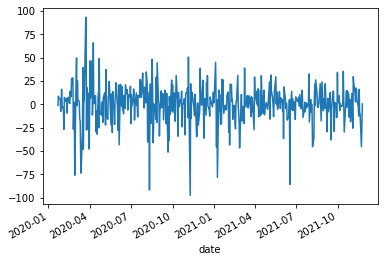

In [ ]:
train['Close_diff1'] = train['Close'] - train['Close'].shift()
train['Close_diff1'].plot()

In [ ]:
# 시계열 정상성 검정
print("ADF test : ", adfuller(train['Close_diff1'].dropna())[1]) # H0: 정상시계열이 아니다.
print("KPSS test : ", kpss(train['Close_diff1'].dropna())[1]) # H0: 정상시계열

ADF test :  9.189157555145372e-20
KPSS test :  0.1


- pmdarima 라이브러리를 통해 금(Gold), 코로나 확진자(cases) 시계열 데이터의 일반차분 차수와 계절차분 차수를 추정하였다.
- 코로나 확진자 시계열 데이터는 일반차분 2번을 하였을 때 정상성이 만족되었다.
- 금은 일반차분 1번을 하면 정상성이 만족되었다.

In [ ]:
# 자동 pmdarima라이버리를 이용하여 모델링 
arima = pm.auto_arima(y = train['Close']       # 데이터
                      , d = 1            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 5   
                      , start_q = 0 
                      , max_q = 5   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

print(arima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4334.232, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4336.227, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4336.227, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4332.479, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4338.227, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.243 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  488
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2165.239
Date:                Sun, 05 Jun 2022   AIC                           4332.479
Time:                        20:39:09   BIC                           4336.667
Sample:                             0   HQIC                          4334.124
                                - 488                                       

In [ ]:
# 최적의 파라미터 대입
from statsmodels.tsa.statespace.sarimax import SARIMAX
arimax = SARIMAX(endog = train['Close'], # Y : Gold Price
                order = (0,1,0),
                seasonal_order = (0,0,0,0),
                ).fit() # freq = 'M'

In [ ]:
# final_fitting
model1 = ARIMA(train['Close'], order=(0,1,0))  # Y : Gold Price
arima = model1.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  488
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2165.239
Date:                Sun, 05 Jun 2022   AIC                           4332.479
Time:                        20:39:11   BIC                           4336.667
Sample:                             0   HQIC                          4334.124
                                - 488                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       425.9344     15.711     27.110      0.000     395.141     456.728
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               364.85
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 금시세를 예측하기 위해서 금시세(종가 기준)와 외생변수(코로나 확진자수)를 통해 ARIMA-X 모형을 적합하시오

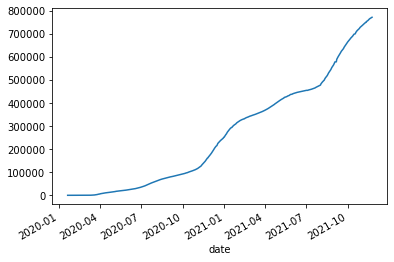

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train['cases'].plot()
plt.show()

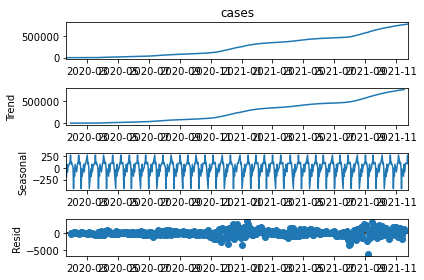

In [ ]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose, STL 
seasonal_decompose(train['cases'], model='add', period=12).plot() # "multiplicative"
plt.show()

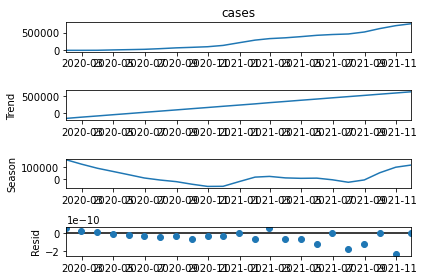

In [ ]:
# STL 시계열 분해(월 계절성 가정)
STL(train['cases'].resample('M').mean(), period=12).fit().plot()
plt.show()

- 강한 추세가 보이며(평균이 일정하지 않으므로 비정상 시계열임) - 일반|계절 차분이 필요
- 계절성이 보이지 않음

In [ ]:
# 정상성 검정
from statsmodels.tsa.stattools import adfuller, kpss
print("ADF test : ", adfuller(train['cases'])[1]) # H0: 정상시계열이 아니다.
print("KPSS test : ", kpss(train['cases'])[1]) # H0: 정상시계열이다.

ADF test :  0.9807954272181669
KPSS test :  0.01


In [ ]:
# 코로나 확진자 차분 차수 추정 
# differencing ? d 
kpss_diffs = ndiffs(train['cases'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train['cases'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(n_diffs)

2


<AxesSubplot:xlabel='date'>

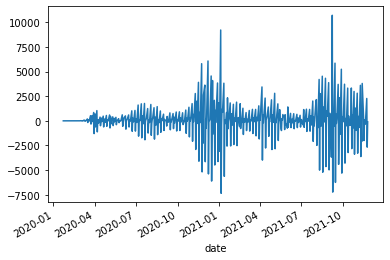

In [ ]:
train['diff1'] = train['cases'] - train['cases'].shift()
train['diff2'] = train['diff1'] - train['diff1'].shift()
train['diff2'].plot()

In [ ]:
# 시계열 정상성 검정
print("ADF test : ", adfuller(train['diff2'].dropna())[1]) # H0: 정상시계열이 아니다.
print("KPSS test : ", kpss(train['diff2'].dropna())[1]) # H0: 정상시계열이다.

ADF test :  0.0
KPSS test :  0.1


In [ ]:
# SARIMAX 라이브러리를 이용하여 모델링 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

p = range(0,3)
d = range(0,2) # before analysis,
q = range(0,3)
P = 0
D = 0  # before analysis,
Q = 0
s = 0 # seasonal period : 12, 7 ,...

pdqPDQs = list(itertools.product(p,d,q)) # Assumtion P, Q,s prediction before analysis

dict_model ={}
for i in pdqPDQs:
    
    model = SARIMAX(train['Close_diff1'].dropna(),
                    exog = train['diff2'].dropna(), # SARIMA or SARIMA-X
                    order=(i[0],d[1],i[2]),
                    seasonal_order = (P,D,Q,s),
                    enforce_stationarity=False, # default 는 True
                    enforce_invertibility=False)  # default 는 True
                    #,freq = 'M')
    #print(i)
    model_fit = model.fit()
        # print("\n ARMA:", i, "\tLL = ", model_fit.llf, "\tAIC = ", model_fit.aic)
    dict_model[i]=[model_fit.llf, model_fit.aic]

    #llf 는 likelihood, AIC -> 0에 가까울 수록 좋음
    

information=pd.DataFrame.from_dict(dict_model, orient ="index", columns =["llf", "AIC"])
information.sort_values(by = ["AIC"], ascending=True) 

,llf,AIC
"(1, 0, 2)",-2151.734334,4313.468668
"(1, 1, 2)",-2151.734334,4313.468668
"(0, 0, 2)",-2153.250824,4314.501648
"(0, 1, 2)",-2153.250824,4314.501648
"(2, 0, 2)",-2152.063300,4316.126599
"(2, 1, 2)",-2152.063300,4316.126599
"(0, 0, 1)",-2157.212441,4320.424881
"(0, 1, 1)",-2157.212441,4320.424881
"(2, 0, 0)",-2157.207557,4322.415115
"(2, 1, 0)",-2157.207557,4322.415115


In [ ]:
# 최적의 파라미터 대입1
from statsmodels.tsa.statespace.sarimax import SARIMAX

model2 = SARIMAX(train['Close'], # Y : Gold Price
                 order=(1,0,2),
                 trend=None, #'c',
                 exog=train['cases'], # exog : covid-19 Cases
                seasonal_order = (0,0,0,0))
arimax = model2.fit()
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  488
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2174.250
Date:                Sun, 05 Jun 2022   AIC                           4358.501
Time:                        20:46:24   BIC                           4379.452
Sample:                             0   HQIC                          4366.730
                                - 488                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cases          0.0002      0.000      0.433      0.665      -0.001       0.001
ar.L1          0.9999      0.000   2612.285      0.000       0.999       1.001
ma.L1          0.0057      0.037      0.154      0.878      -0.067       0.079
ma.L2         -0.0182      0.035     -0.514      0.607      -0.088       0.051
sigma2       433.7597     17.241     25.159      0.000     399.968     467.551
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               365.84
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train.index.max()

Timestamp('2021-11-24 00:00:00')

### 위 두 모델에 대한 예측결과를 시각화 하시오

In [ ]:
## RMSE

def rmse(real, pred):
    diff = real-pred
    diff2=np.sqrt(diff**2)
    return diff2.mean()

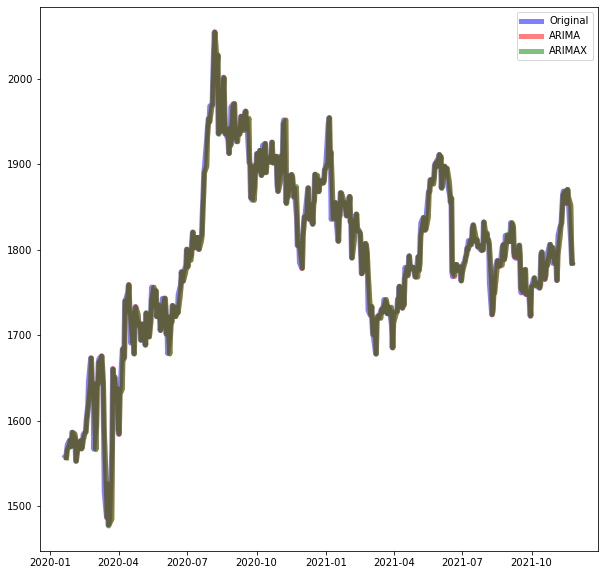

14.214197530864192
14.20599042836783


In [ ]:
## Fitting
start_date = '2020-01-23' #'2020-01-21' + 2일 
end_date = '2021-11-24' ## '2022-02-16'


train["prediction_arima"] = arima.predict(start = start_date, end = end_date)
train["prediction_arimax"] = arimax.predict(start = start_date, end = end_date, exog = train["cases"])
fig= plt.figure(figsize = (10,10))

plt.plot(train["Close"] , "b-", label = "Original" , alpha = 0.5, lw=5) # 원래 금가격
plt.plot(train["prediction_arima"] , "r-", label = "ARIMA" , alpha = 0.5, lw=5)
plt.plot(train["prediction_arimax"] , "g-" , label = "ARIMAX" , alpha = 0.5, lw=5) 
plt.legend()

plt.show()



print(rmse(train["Close"], train["prediction_arima"])) ##14.214197530864192
print(rmse(train["Close"], train["prediction_arimax"])) ##14.20599042836783

In [ ]:
## Forecasting
steps = len(test)

pred_arima = pd.DataFrame(arima.forecast(steps)).reset_index(drop=True)
pred_arima.index = test.index
pred_arima.head(2)

pred_arimax = pd.DataFrame(arimax.forecast(steps, exog = test["cases"])).reset_index(drop=True)
pred_arimax.index = test.index
pred_arimax.head(2)

,predicted_mean
date,
2021-11-25,1784.473247
2021-11-26,1784.243233


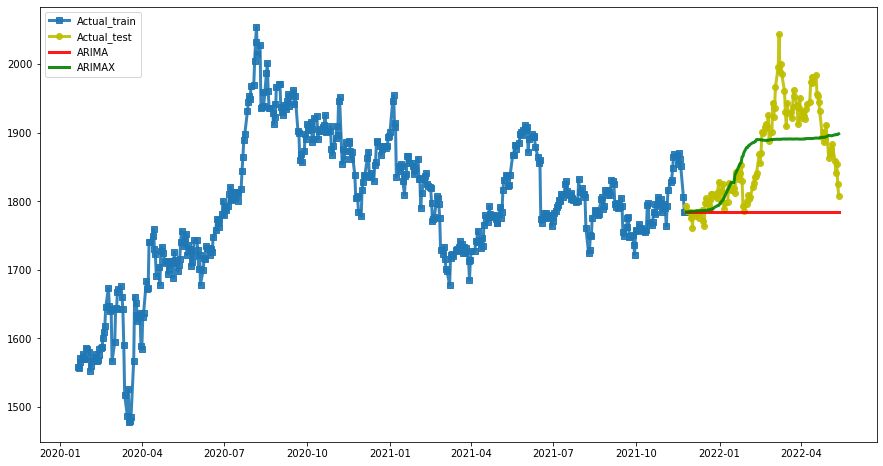

83.77276422764227
34.772560383648866


In [ ]:
fig= plt.figure(figsize = (15,8))
plt.plot(train["Close"], "s-", label = "Actual_train", alpha = 0.9, lw=3)
plt.plot(test["Close"], "o-", label = "Actual_test", alpha = 0.9, lw=3,color='y')
plt.plot(pred_arima , "r-", label = "ARIMA" , alpha = 0.9, lw=3)
plt.plot(pred_arimax , "g-" , label = "ARIMAX" , alpha = 0.9, lw=3)
plt.legend()

plt.show()

print(rmse(test["Close"],pred_arima['predicted_mean']))  # 83.77276422764227
print(rmse(test["Close"],pred_arimax['predicted_mean']))  # 34.772560383648866

###  위 두 모델에 대한 잔차분석을 시행하시오.

In [ ]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(arima.resid,return_df = True) 

,lb_stat,lb_pvalue
1,0.000758,0.978037
2,0.013462,0.993292
3,0.017636,0.999380
4,0.031981,0.999874
5,0.066511,0.999941
6,0.099685,0.999980
7,0.118026,0.999996
8,0.118316,1.000000
9,0.120329,1.000000
10,0.200408,1.000000


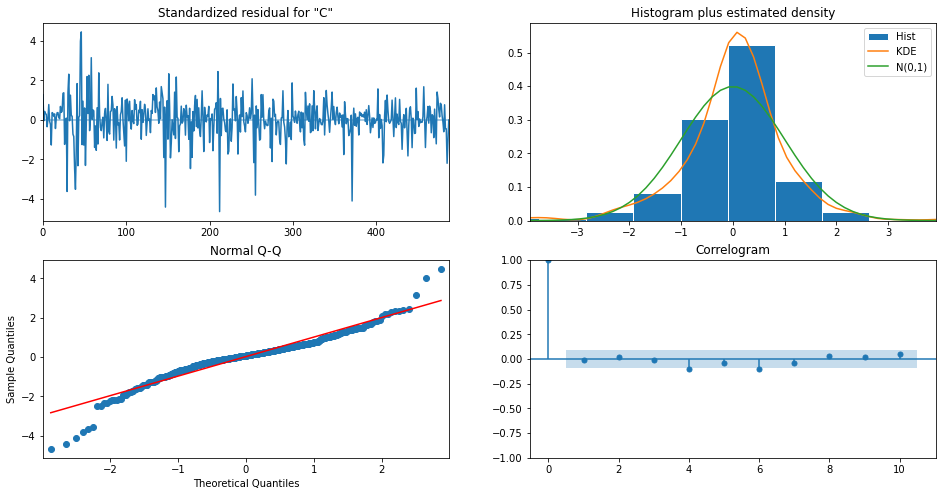

In [ ]:
arimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(arimax.resid,return_df = True) 

,lb_stat,lb_pvalue
1,0.001121,0.973296
2,0.022422,0.988852
3,0.026936,0.998834
4,0.040206,0.999801
5,0.073223,0.999925
6,0.104563,0.999977
7,0.123424,0.999995
8,0.123759,0.999999
9,0.125355,1.000000
10,0.200235,1.000000
